---
title: "Visual Prompter: Segment Anything"
description: "This tutorials shows how to use our high-level API *Visual Prompter*. This API allow to set an image, and run multiple queries multiple times on this image. These query can be done with three types of prompts."
author:
    - "João G. Atkinson"
date: 04-18-2023
categories:
    - Intermediate
    - Segmentation
    - kornia.contrib
image: "../tutorials/assets/visual_prompter.png"
---

<a href="https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/visual_prompter.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in google colab"></a>

This tutorials shows how to use our high-level API *Visual Prompter*. This API allow to set an image, and run multiple queries multiple times on this image. These query can be done with three types of prompt:

1. Points: Keypoints with `(x, y)` and a respective label. Where 0 indicates a background point; 1 indicates a foreground point;
2. Boxes: Boxes of different regions.
3. Masks: Logits generated by the model in a previous run.


Read more on our docs: https://kornia.readthedocs.io/en/latest/models/segment_anything.html

This tutorials steps:

1. [Setup the desired SAM model and import the necessary packages](#setup)
    1. [Utilities function to read and plot the data](#utilities-functions)
1. [How to instantiate the Visual Prompter](#exploring-the-visual-prompter)
    1. [How to set an image](#set-image)
    1. [The supported prompts type](#examples-of-prompts)
    1. [Example how to query on the image](#example-of-prediction)
    1. [Prediction structure](#exploring-the-prediction-result-structure)
1. [Using the Visual Prompter](#using-the-visual-prompter-on-examples)
    1. [Soccer player segmentation](#soccer-players)
    1. [Car parts segmentation](#car-parts)
    1. [Satellite image - Sentinel-2](#satellite-image)

## Setup

In [1]:
%%capture
!pip install kornia
!pip install kornia-rs

First let's choose the SAM type to be used on our Visual Prompter.

The options are (smaller to bigger):

| model_type | checkpoint official                                                  |
| ---------- | -------------------------------------------------------------------- |
| vit_b      | https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth |
| vit_l      | https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth |
| vit_h      | https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth |

In [2]:
model_type = "vit_h"
checkpoint = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

Then let's import all necessary packages and modules

In [3]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import torch
from kornia.contrib.models.sam import SamConfig
from kornia.contrib.visual_prompter import VisualPrompter
from kornia.geometry.boxes import Boxes
from kornia.geometry.keypoints import Keypoints
from kornia.io import ImageLoadType, load_image
from kornia.utils import get_cuda_or_mps_device_if_available, tensor_to_image

In [4]:
device = get_cuda_or_mps_device_if_available()
print(device)

None


### Utilities functions

In [5]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


soccer_image_path = download_image("https://raw.githubusercontent.com/kornia/data/main/soccer.jpg")
car_image_path = download_image("https://raw.githubusercontent.com/kornia/data/main/simple_car.jpg")
satellite_image_path = download_image("https://raw.githubusercontent.com/kornia/data/main/satellite_sentinel2_example.tif")
soccer_image_path, car_image_path, satellite_image_path

('soccer.jpg', 'simple_car.jpg', 'satellite_sentinel2_example.tif')

In [6]:
def colorize_masks(binary_masks: torch.Tensor, merge: bool = True, alpha: None | float = None) -> list[torch.Tensor]:
    """Convert binary masks (B, C, H, W), boolean tensors, into masks with colors (B, (3, 4) , H, W) - RGB or RGBA. Where C refers to the number of masks.
    Args:
        binary_masks: a batched boolean tensor (B, C, H, W)
        merge: If true, will join the batch dimension into a unique mask.
        alpha: alpha channel value. If None, will generate RGB images

    Returns:
        A list of `C` colored masks.
    """
    B, C, H, W = binary_masks.shape
    OUT_C = 4 if alpha else 3

    output_masks = []

    for idx in range(C):
        _out = torch.zeros(B, OUT_C, H, W, device=binary_masks.device, dtype=torch.float32)
        for b in range(B):
            color = torch.rand(1, 3, 1, 1, device=binary_masks.device, dtype=torch.float32)
            if alpha:
                color = torch.cat([color, torch.tensor([[[[alpha]]]], device=binary_masks.device, dtype=torch.float32)], dim=1)

            to_colorize = binary_masks[b, idx, ...].view(1, 1, H, W).repeat(1, OUT_C, 1, 1)
            _out[b, ...] = torch.where(to_colorize, color, _out[b, ...])
        output_masks.append(_out)

    if merge:
        output_masks = [c.max(dim=0)[0] for c in output_masks]

    return output_masks


def show_binary_masks(binary_masks: torch.Tensor, axes) -> None:
    """plot binary masks, with shape (B, C, H, W), where C refers to the number of masks.

    will merge the `B` channel into a unique mask.
    Args:
        binary_masks: a batched boolean tensor (B, C, H, W)
        ax: a list of matplotlib axes with lenght of C
    """
    colored_masks = colorize_masks(binary_masks, True, 0.6)

    for ax, mask in zip(axes, colored_masks):
        ax.imshow(tensor_to_image(mask))


def show_boxes(boxes: Boxes, ax) -> None:
    boxes_tensor = boxes.to_tensor(mode="xywh").detach().cpu().numpy()
    for box in boxes_tensor:
        x0, y0, w, h = box
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="orange", facecolor=(0, 0, 0, 0), lw=2))


def show_points(points: tuple[Keypoints, torch.Tensor], ax, marker_size=200):
    coords, labels = points
    pos_points = coords[labels == 1].to_tensor().detach().cpu().numpy()
    neg_points = coords[labels == 0].to_tensor().detach().cpu().numpy()

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="+", s=marker_size, linewidth=2)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="x", s=marker_size, linewidth=2)

In [7]:
from kornia.contrib.models import SegmentationResults


def show_image(image: torch.Tensor):
    plt.imshow(tensor_to_image(image))
    plt.axis("off")
    plt.show()


def show_predictions(
    image: torch.Tensor,
    predictions: SegmentationResults,
    points: tuple[Keypoints, torch.Tensor] | None = None,
    boxes: Boxes | None = None,
) -> None:
    n_masks = predictions.logits.shape[1]

    fig, axes = plt.subplots(1, n_masks, figsize=(21, 16))
    axes = [axes] if n_masks == 1 else axes

    for idx, ax in enumerate(axes):
        score = predictions.scores[:, idx, ...].mean()
        ax.imshow(tensor_to_image(image))
        ax.set_title(f"Mask {idx+1}, Score: {score:.3f}", fontsize=18)

        if points:
            show_points(points, ax)

        if boxes:
            show_boxes(boxes, ax)

        ax.axis("off")

    show_binary_masks(predictions.binary_masks, axes)
    plt.show()

## Exploring the Visual Prompter

The `VisualPrompter` can be initialized from a ModelConfig structure, where now we just have support for the SAM model through the `SamConfig`. Through this config the `VisualPrompter` will initialize the SAM model and load the weights (from a path or a URL).

What the `VisualPrompter` can do?
1. Based on the ModelConfig, besides the model initialization, we will setup the required transformations for the images and prompts using the [kornia.augmentation API](https://kornia.readthedocs.io/en/latest/augmentation.container.html/augmentation.html) within the Augmentation [sequential container](https://kornia.readthedocs.io/en/latest/augmentation.container.html#augmentation-sequential).
1. You can benefit from using the `torch.compile(...)` API (dynamo) for torch >= 2.0.0 versions. To compile with dynamo we provide the method `VisualPrompter.compile(...)` which will optimize the right parts of the backend model and the prompter itself.
1. Caching the image features and transformations. With the `VisualPrompter.set_image(...)` method, we transform the image and already encode it using the model, caching it's embeddings to query later.
1. Query multiple times with multiple prompts. Using the `VisualPrompter.predict(...)`, where we will query on our cached embeddings using Keypoints, Boxes and Masks as prompt. 

What the `VisualPrompter` and Kornia provides?
Easy high-levels structures to be used as prompt, also as the result of the prediction. Using the [kornia geometry module](https://kornia.readthedocs.io/en/latest/geometry.html) you can easily encapsulate the Keypoints and Boxes, which allow the API to be more flexible about the desired mode (mainly for boxes, where we had multiple modes of represent it).

The Kornia `VisualPrompter` and model config for SAM can be imported as follow:

```python
from kornia.contrib.image_prompter import VisualPrompter
from kornia.contrib.models import SamConfig
```

In [8]:
# Setting up a SamConfig with the model type and checkpoint desired
config = SamConfig(model_type, checkpoint)

# Initialize the VisualPrompter
prompter = VisualPrompter(config, device=device)

### Set image

First, before adding the image to the prompter, we need to read the image. For that, we can use [kornia.io](https://kornia.readthedocs.io/en/latest/io.html), which internally uses [kornia-rs](https://github.com/kornia/kornia-rs). If you do not have `kornia-rs` installed, you can install it with `pip install kornia_rs`. This API implements the [DLPack](https://github.com/dmlc/dlpack) protocol natively in Rust to reduce the memory footprint during the decoding and type conversion. Allowing us to read the image from the disk directly to a tensor. Note that the image should be scaled within the range [0,1].

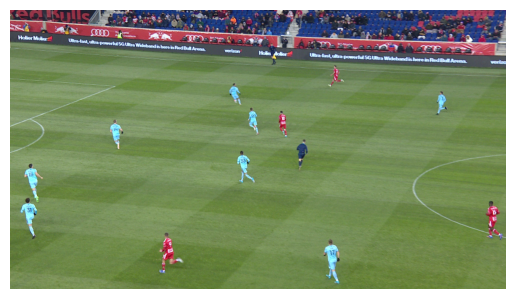

In [9]:
# Load the image
image = load_image(soccer_image_path, ImageLoadType.RGB32, device)  # 3 x H x W

# Display the loaded image
show_image(image)

With the image loaded onto the same device as the model, and with the right shape `3xHxW`, we can now set the image in our image prompter. Attention: when doing this, the model will compute the embeddings of this image; this means, we will pass this image through the encoder, which will use a lot of memory. It is possible to use the largest model (vit-h) with a graphic card (GPU) that has at least 8Gb of VRAM. 

In [10]:
prompter.set_image(image)

If no error occurred, the features needed to run queries are now cached. If you want to check this, you can see the status of the `prompter.is_image_set` property.

In [11]:
prompter.is_image_set

True

### Examples of prompts

The `VisualPrompter` output will have the same Batch Size that its prompts. Where the output shape will be **(B, C, H, W)**. Where `B` is the number of input prompts, `C` is determined by multimask output parameter. If `multimask_output` is True than `C=3`, otherwise `C=1`

#### Keypoints

Keypoints prompts is a tensor or a [Keypoint structure](https://kornia.readthedocs.io/en/latest/geometry.keypoints.html) within coordinates into (x, y). With shape **BxNx2**.

For each coordinate pair, should have a corresponding label, where 0 indicates a background point; 1 indicates a foreground point; These labels should be in a tensor with shape **BxN**

The model will try to find a object within all the foreground points, and without the background points. In other words, the foreground points can be used to select the desired type of data, and the background point to exclude the type of data. 

In [12]:
keypoints_tensor = torch.tensor([[[960, 540]]], device=device, dtype=torch.float32)
keypoints = Keypoints(keypoints_tensor)

labels = torch.tensor([[1]], device=device, dtype=torch.float32)

#### Boxes

Boxes prompts is a tensor a with boxes on "xyxy" format/mode, or a [Boxes structure](https://kornia.readthedocs.io/en/latest/geometry.boxes.html). Tensor should have a shape of **BxNx4**.

In [13]:
boxes_tensor = torch.tensor([[[1841.7, 739.0, 1906.5, 890.6]]], device=device, dtype=torch.float32)
boxes = Boxes.from_tensor(boxes_tensor, mode="xyxy")

#### Masks

Masks prompts should be provide from a previous model output, with shape **Bx1x256x256**

```python
# first run
predictions = prompter.prediction(...)

# use previous results as prompt
predictions = prompter.prediction(..., mask=predictions.logits)

```

### Example of prediction

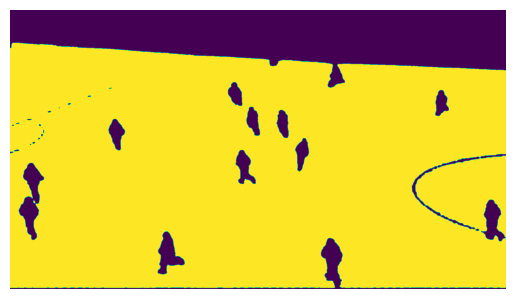

In [14]:
# using keypoints
prediction_by_keypoint = prompter.predict(keypoints, labels, multimask_output=False)

show_image(prediction_by_keypoint.binary_masks)

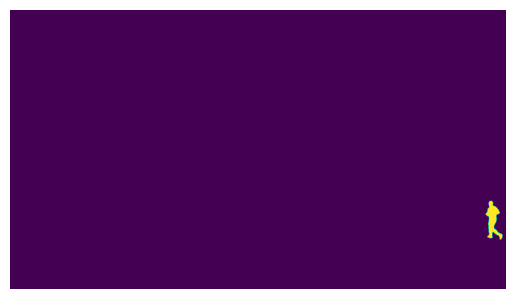

In [15]:
# Using boxes
prediction_by_boxes = prompter.predict(boxes=boxes, multimask_output=False)

show_image(prediction_by_boxes.binary_masks)

### Exploring the prediction result structure

The `VisualPrompter` prediction structure, is a [`SegmentationResults`](https://kornia.readthedocs.io/en/latest/contrib.html#SegmentationResults) which has the upscaled (default) logits when `output_original_size=True` is passed on the predict.

The segmentation results have:
- logits: Results logits with shape `(B, C, H, W)`, where `C` refers to the number of predicted masks
- scores: The scores from the logits. Shape `(B,)`
- Binary mask generated from logits considering the mask_threshold. The size depends on `original_res_logits=True`, if false, the binary mask will have the same shape of the logits **Bx1x256x256**

In [16]:
prediction_by_boxes.scores

tensor([[0.9317]])

In [17]:
prediction_by_boxes.binary_masks.shape

torch.Size([1, 1, 1080, 1920])

In [18]:
prediction_by_boxes.logits.shape

torch.Size([1, 1, 256, 256])

## Using the Visual Prompter on examples

### Soccer players

Using an example image from the dataset: https://www.kaggle.com/datasets/ihelon/football-player-segmentation

Lets segment the persons on the field using boxes

In [19]:
# Prompts
boxes = Boxes.from_tensor(
    torch.tensor(
        [
            [1841.7000, 739.0000, 1906.5000, 890.6000],
            [879.3000, 545.9000, 948.2000, 669.2000],
            [55.7000, 595.0000, 127.4000, 745.9000],
            [1005.4000, 128.7000, 1031.5000, 212.0000],
            [387.4000, 424.1000, 438.2000, 539.0000],
            [921.0000, 377.7000, 963.3000, 483.0000],
            [1213.2000, 885.8000, 1276.2000, 1060.1000],
            [40.8900, 725.9600, 105.4100, 886.5800],
            [848.9600, 283.6200, 896.0600, 368.6200],
            [1109.6500, 499.0400, 1153.0400, 622.1700],
            [576.3000, 860.8000, 671.7000, 1018.8000],
            [1039.8000, 389.9000, 1072.5000, 493.2000],
            [1647.1000, 315.1000, 1694.0000, 406.0000],
            [1231.2000, 214.0000, 1294.1000, 297.3000],
        ],
        device=device,
    ),
    mode="xyxy",
)

In [20]:
# Load the image
image = load_image(soccer_image_path, ImageLoadType.RGB32, device)  # 3 x H x W

# Set the image
prompter.set_image(image)

In [21]:
predictions = prompter.predict(boxes=boxes, multimask_output=True)

let's see the results, since we used `multimask_output=True`, the model outputted 3 masks.

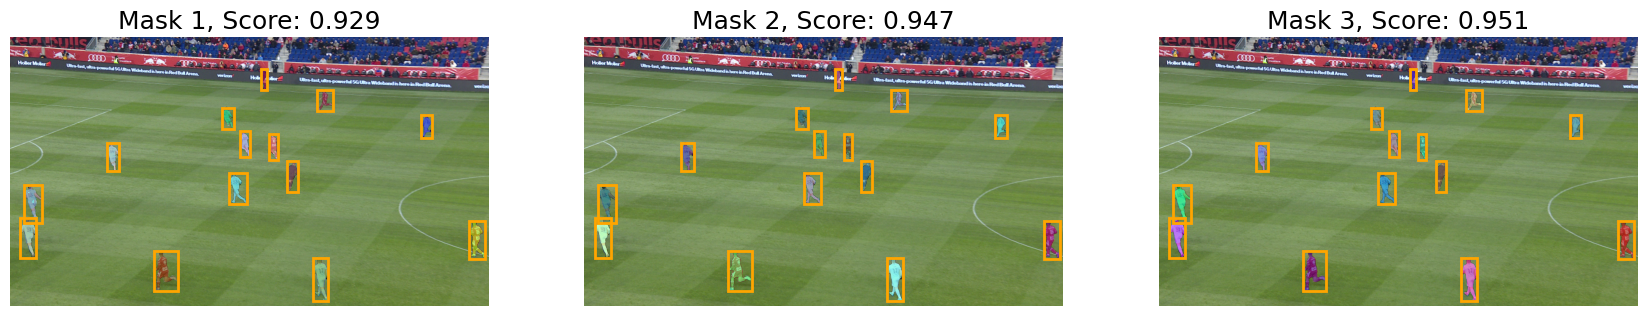

In [22]:
show_predictions(image, predictions, boxes=boxes)

### Car parts

Segmenting car parts of an example from the dataset: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset

In [23]:
# Prompts
boxes = Boxes.from_tensor(
    torch.tensor(
        [
            [56.2800, 369.1100, 187.3000, 579.4300],
            [412.5600, 426.5800, 592.9900, 608.1600],
            [609.0800, 366.8200, 682.6400, 431.1700],
            [925.1300, 366.8200, 959.6100, 423.1300],
            [756.1900, 416.2300, 904.4400, 473.7000],
            [489.5600, 285.2200, 676.8900, 343.8300],
        ],
        device=device,
    ),
    mode="xyxy",
)

keypoints = Keypoints(
    torch.tensor(
        [[[535.0, 227.0], [349.0, 215.0], [237.0, 219.0], [301.0, 373.0], [641.0, 397.0], [489.0, 513.0]]], device=device
    )
)
labels = torch.ones(keypoints.shape[:2], device=device, dtype=torch.float32)

In [24]:
# Image
image = load_image(car_image_path, ImageLoadType.RGB32, device)

# Set the image
prompter.set_image(image)

#### Querying with boxes

In [25]:
predictions = prompter.predict(boxes=boxes, multimask_output=True)

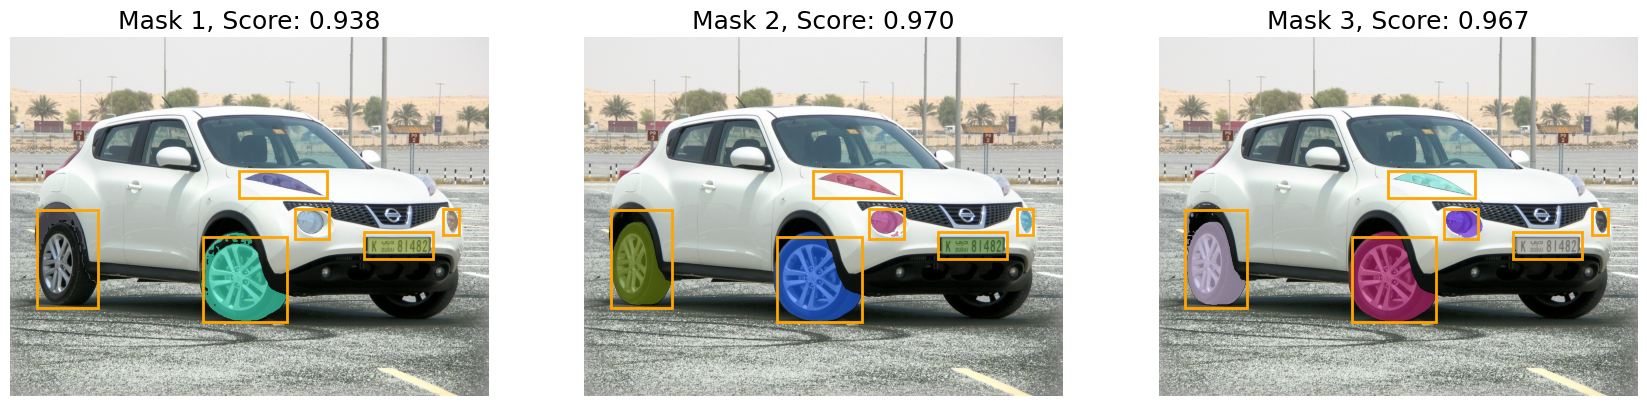

In [26]:
show_predictions(image, predictions, boxes=boxes)

#### Querying with keypoints

##### Considering N points into 1 Batch

This way the model will kinda find the object within all the points

In [27]:
predictions = prompter.predict(keypoints=keypoints, keypoints_labels=labels)

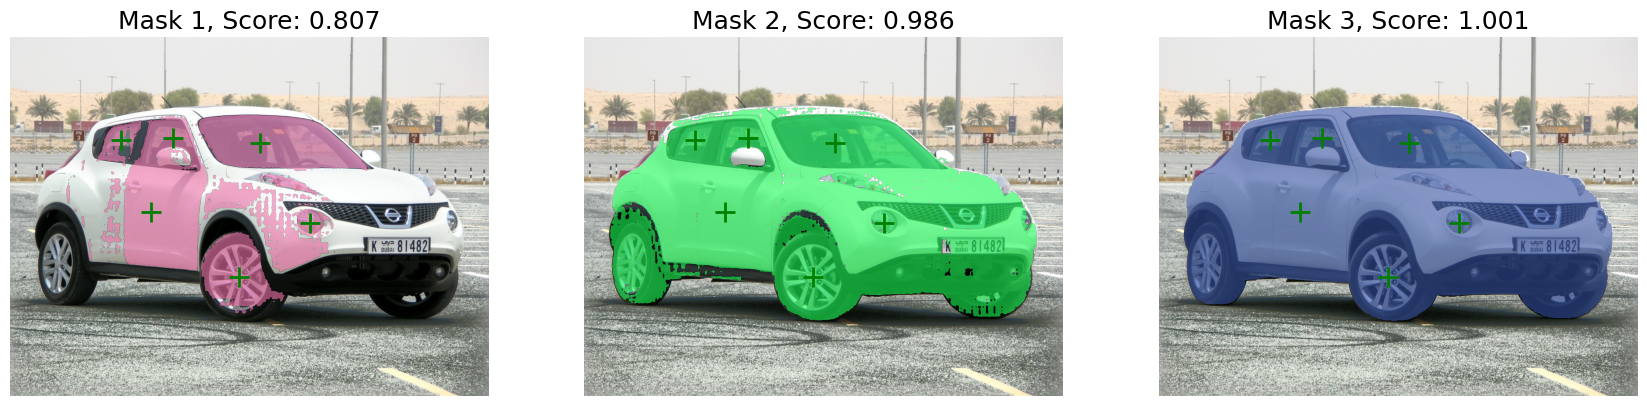

In [28]:
show_predictions(image, predictions, points=(keypoints, labels))

##### Considering 1 point into N Batch

Prompter encoder not working for a batch of points :/

#### Considering 1 point for batch into N queries

This way the model will find an object for each point

------------------------------------------------------------------------------- 
Query 0:


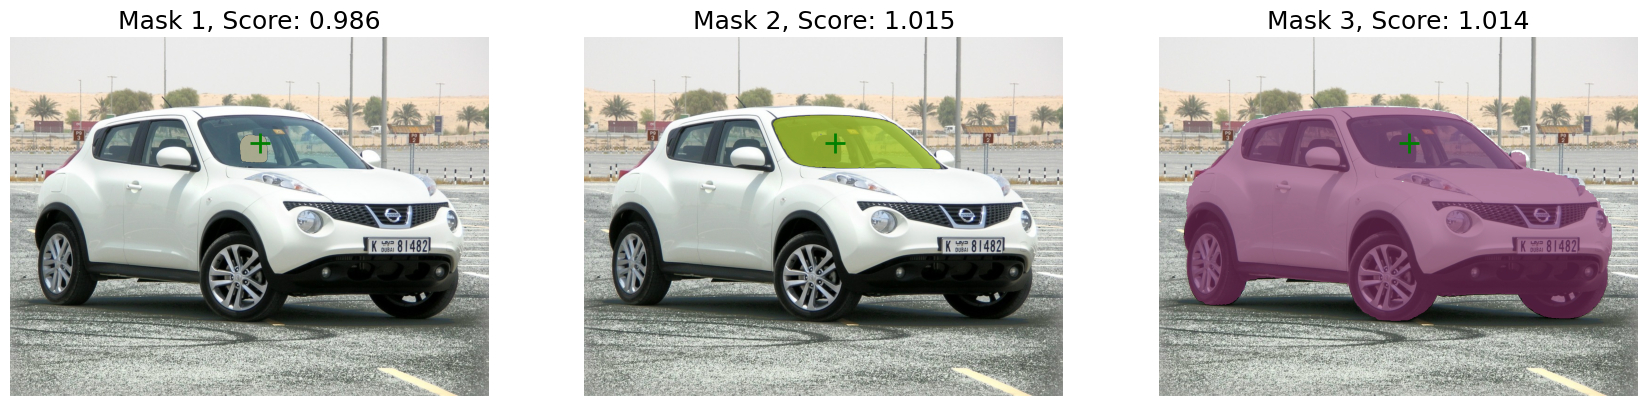

------------------------------------------------------------------------------- 
Query 1:


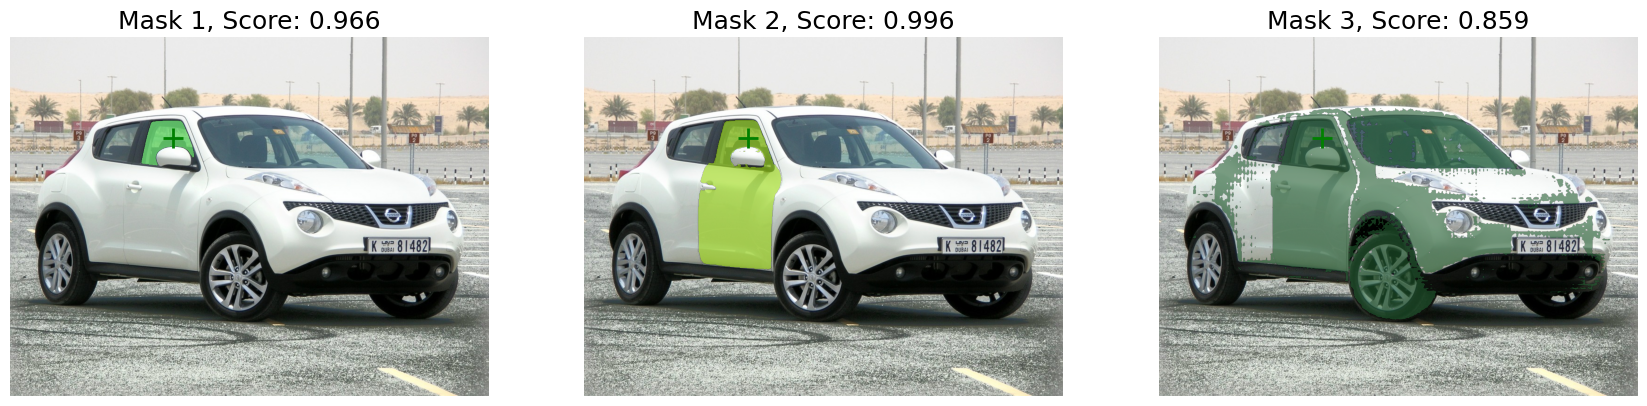

In [29]:
k = 2  # number of times/points to query

for idx in range(min(keypoints.data.size(1), k)):
    print("-" * 79, f"\nQuery {idx}:")
    _kpts = keypoints[:, idx, ...][None, ...]
    _lbl = labels[:, idx, ...][None, ...]

    predictions = prompter.predict(keypoints=_kpts, keypoints_labels=_lbl)

    show_predictions(image, predictions, points=(_kpts, _lbl))

### Satellite image

Image from Sentinel-2

Product: A tile of the TCI (px of 10m).
Product name: `S2B_MSIL1C_20230324T130249_N0509_R095_T23KPQ_20230324T174312`

In [30]:
# Prompts
keypoints = Keypoints(
    torch.tensor(
        [
            [
                # Urban
                [74.0, 104.5],
                [335, 110],
                [702, 65],
                [636, 479],
                [408, 820],
                # Forest
                [40, 425],
                [680, 566],
                [405, 439],
                [73, 689],
                [865, 460],
                # Ocean/water
                [981, 154],
                [705, 714],
                [357, 683],
                [259, 908],
                [1049, 510],
            ]
        ],
        device=device,
    )
)
labels = torch.ones(keypoints.shape[:2], device=device, dtype=torch.float32)

In [31]:
# Image
image = load_image(satellite_image_path, ImageLoadType.RGB32, device)

# Set the image
prompter.set_image(image)

#### Query urban points

In [32]:
# Query the prompts
labels_to_query = labels.clone()
labels_to_query[..., 5:] = 0

predictions = prompter.predict(keypoints=keypoints, keypoints_labels=labels_to_query)

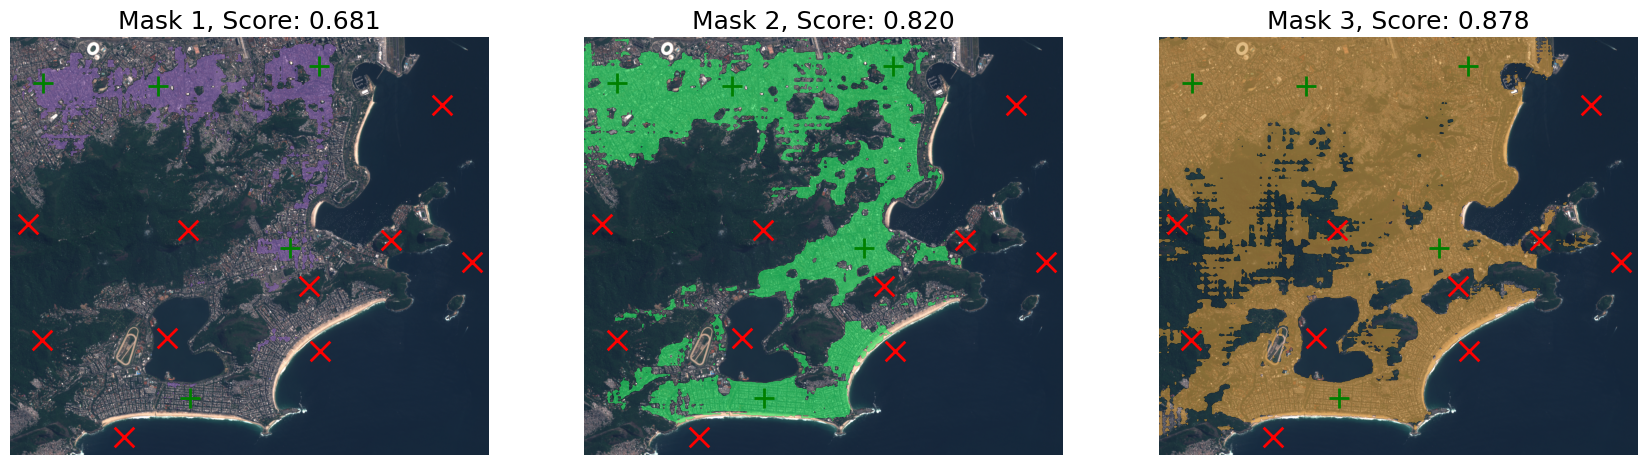

In [33]:
show_predictions(image, predictions, points=(keypoints, labels_to_query))

#### Query Forest points

In [34]:
# Query the prompts
labels_to_query = labels.clone()
labels_to_query[..., :5] = 0
labels_to_query[..., 10:] = 0

predictions = prompter.predict(keypoints=keypoints, keypoints_labels=labels_to_query)

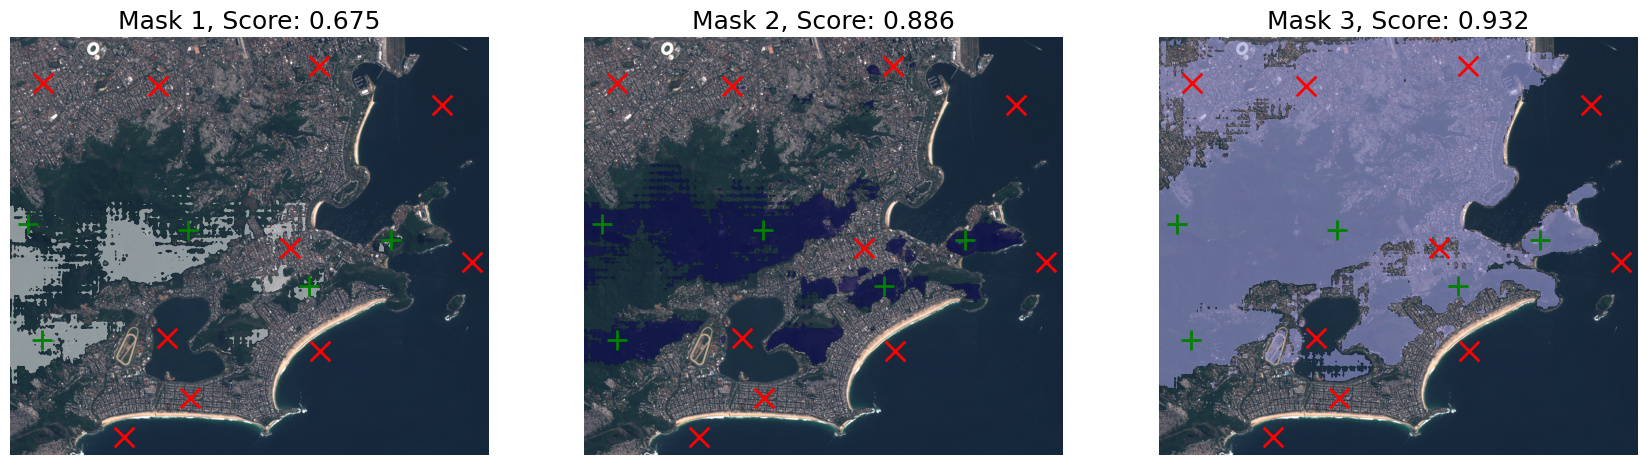

In [35]:
show_predictions(image, predictions, points=(keypoints, labels_to_query))

#### Query ocean/water points

In [36]:
# Query the prompts
labels_to_query = labels.clone()
labels_to_query[..., :10] = 0

predictions = prompter.predict(keypoints=keypoints, keypoints_labels=labels_to_query)

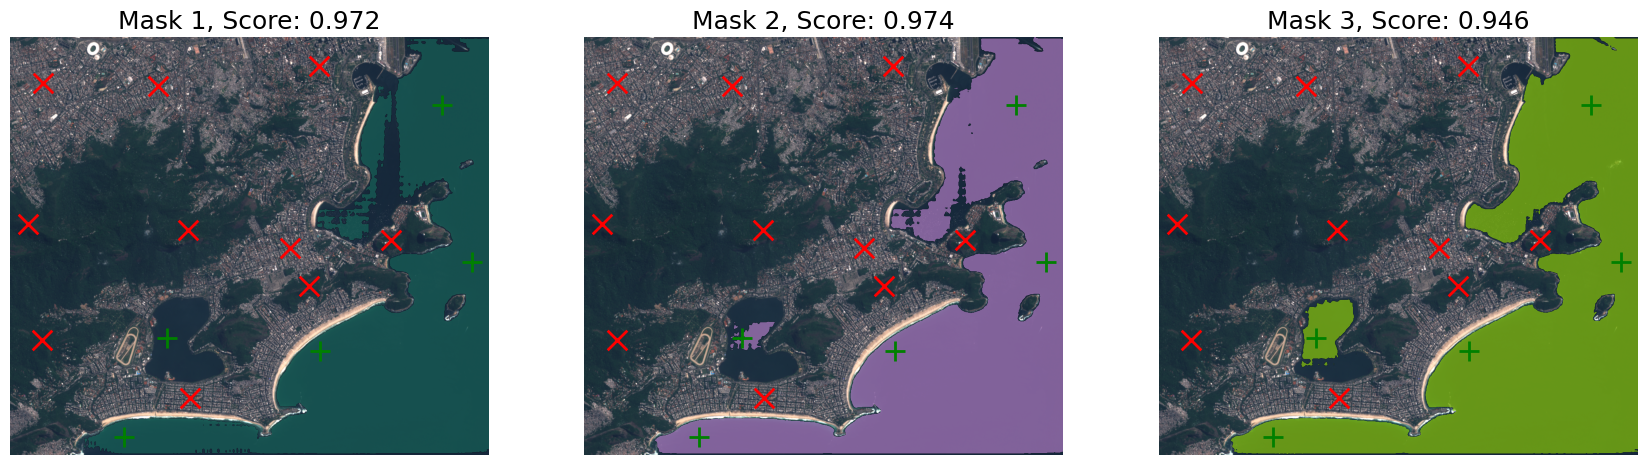

In [37]:
show_predictions(image, predictions, points=(keypoints, labels_to_query))